In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
# 1
# Assuming your CSV file is loaded into a DataFrame df
df = pd.read_csv("final_merged_data.csv")

# Drop rows where the GWQ indicator or SDP is missing
df = df.dropna(subset=['Amount.of.Electrical.Conductivity', 'SDP'])

# Define the dependent variable (Y) and the independent variable (X)
Y = df['Amount.of.Electrical.Conductivity']  
X = df['SDP'] 

# Add a constant to the independent variable, as statsmodels doesn't do it by default
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())


                                    OLS Regression Results                                   
Dep. Variable:     Amount.of.Electrical.Conductivity   R-squared:                       0.015
Model:                                           OLS   Adj. R-squared:                  0.015
Method:                                Least Squares   F-statistic:                     131.3
Date:                               Sun, 28 Apr 2024   Prob (F-statistic):           3.64e-30
Time:                                       15:19:52   Log-Likelihood:                -69473.
No. Observations:                               8357   AIC:                         1.390e+05
Df Residuals:                                   8355   BIC:                         1.390e+05
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

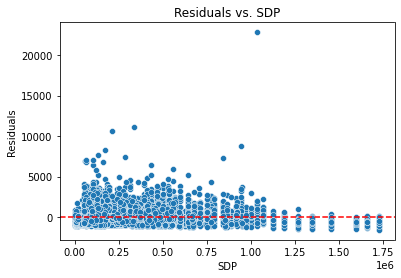

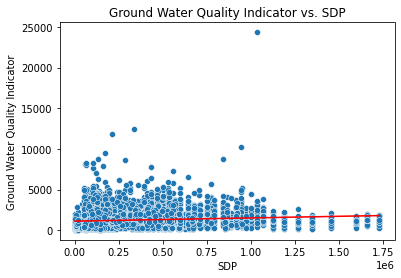

In [3]:
# 2
# Assuming `model` is the fitted OLS model from statsmodels
residuals = model.resid
fitted_values = model.fittedvalues
sdp = df['SDP']
ground_water_quality = df['Amount.of.Electrical.Conductivity']

# Plotting the residuals
sns.scatterplot(x=sdp, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('SDP')
plt.ylabel('Residuals')
plt.title('Residuals vs. SDP')
# plt.savefig('residual_sdp.jpg')
plt.show()

# Plotting the groundwater quality indicator against SDP
sns.scatterplot(x=sdp, y=ground_water_quality)
sns.lineplot(x=sdp, y=fitted_values, color='red')
plt.xlabel('SDP')
plt.ylabel('Ground Water Quality Indicator')
plt.title('Ground Water Quality Indicator vs. SDP')
plt.show()
# plt.savefig('waterqual_sdp.jpg')
# To interpret, you would look at the coefficient of SDP (β1) and its significance level

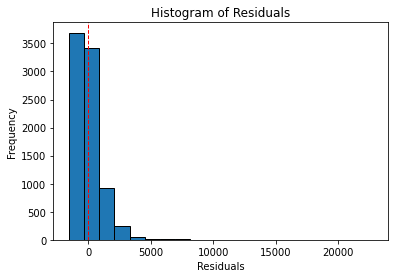

Sum of residuals:  6.5338099375367165e-09


In [4]:
#3
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

# To verify that the sum of the residuals is zero
sum_residuals = residuals.sum()
print("Sum of residuals: ", sum_residuals)


In [7]:
# Add a squared SDP term to df to capture the non-linear relationship
df['SDP_squared'] = df['SDP'] ** 2

# Define the dependent variable and the independent variables including the squared term
Y = df['Amount.of.Electrical.Conductivity']  # replace with your specific quality indicator variable
X = df[['SDP', 'SDP_squared']]

# Add a constant term to the independent variables for the intercept
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the regression model
model_summary = model.summary()
print(model_summary)


                                    OLS Regression Results                                   
Dep. Variable:     Amount.of.Electrical.Conductivity   R-squared:                       0.039
Model:                                           OLS   Adj. R-squared:                  0.039
Method:                                Least Squares   F-statistic:                     170.8
Date:                               Sun, 28 Apr 2024   Prob (F-statistic):           2.06e-73
Time:                                       15:24:22   Log-Likelihood:                -69371.
No. Observations:                               8357   AIC:                         1.387e+05
Df Residuals:                                   8354   BIC:                         1.388e+05
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
                  coef    std err          t      P>|t|     

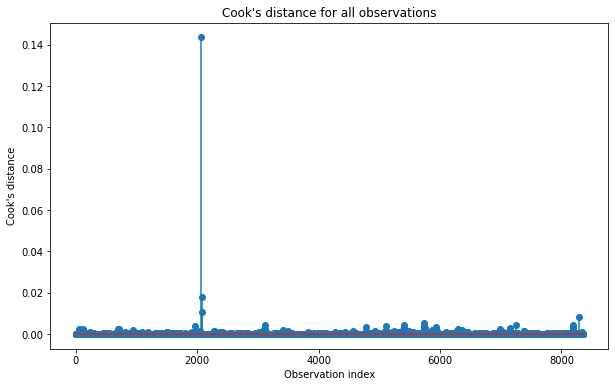

          District           State     YearCode  District.Code   State.Code  \
count         8357            8357  8357.000000    8357.000000  8357.000000   
unique         605              30          NaN            NaN          NaN   
top     Pratapgarh  Madhya Pradesh          NaN            NaN          NaN   
freq            23             893          NaN            NaN          NaN   
mean           NaN             NaN  2009.190379     364.135814    19.987436   
std            NaN             NaN     5.449451     192.066656    10.001183   
min            NaN             NaN  2000.000000       1.000000     1.000000   
25%            NaN             NaN  2004.000000     198.000000     9.000000   
50%            NaN             NaN  2009.000000     398.000000    22.000000   
75%            NaN             NaN  2014.000000     513.000000    27.000000   
max            NaN             NaN  2018.000000     721.000000    38.000000   

        Amount.of.Arsenic  Amount.of.carbonate  Amo

In [10]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Calculate influence measures
test_class = OLSInfluence(model)

# Get Cook's distance
cooks_d = test_class.cooks_distance[0]

# Identify potential influential points (common threshold is 4/n)
n = len(df)
influential_threshold = 4 / n
influential_points = cooks_d > influential_threshold

# Plot Cook's distance
plt.figure(figsize=(10,6))
plt.stem(cooks_d, use_line_collection=True)
plt.hlines(influential_threshold, 0, len(cooks_d), colors='r', linestyles='dashed')
plt.title("Cook's distance for all observations")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.show()

# Prepare a detailed summary statistics table
summary_stats = df.describe(include='all')

# For outliers, one approach is to remove observations with a Cook's distance greater than the threshold
df_filtered = df.loc[~influential_points, :]
print(summary_stats)


In [16]:
import patsy  # for creating design matrices

# Assuming df is your DataFrame with the necessary data

# Create a 'YearCode' categorical variable for the year dummies
df['YearCode'] = df['YearCode'].astype('category')

# Use patsy to create design matrices
y, X = patsy.dmatrices('Q("Amount.of.Electrical.Conductivity") ~ SDP + I(SDP ** 2) + YearCode', data=df, return_type='dataframe')

# Fit the OLS regression model with year dummies
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
model_summary = model.summary()
print(model_summary)


                                      OLS Regression Results                                      
Dep. Variable:     Q("Amount.of.Electrical.Conductivity")   R-squared:                       0.076
Model:                                                OLS   Adj. R-squared:                  0.074
Method:                                     Least Squares   F-statistic:                     34.20
Date:                                    Sun, 28 Apr 2024   Prob (F-statistic):          1.54e-126
Time:                                            15:49:57   Log-Likelihood:                -69209.
No. Observations:                                    8357   AIC:                         1.385e+05
Df Residuals:                                        8336   BIC:                         1.386e+05
Df Model:                                              20                                         
Covariance Type:                                nonrobust                                         
          

In [21]:
import pandas as pd
import statsmodels.api as sm
import patsy

# Load your data
df = pd.read_csv('final_merged_data.csv')

# Define a mapping from states to regions based on the provided information
region_mapping = {
    'Chandigarh': 'NORTHERN_REGION', 
    'Delhi': 'NORTHERN_REGION',
    'Haryana': 'NORTHERN_REGION',
    'Himachal Pradesh': 'NORTHERN_REGION',
    'Jammu & Kashmir': 'NORTHERN_REGION',
    'Punjab': 'NORTHERN_REGION',
    'Rajasthan': 'NORTHERN_REGION',
    'Arunachal Pradesh': 'NORTH-EASTERN_REGION',
    'Assam': 'NORTH-EASTERN_REGION',
    'Manipur': 'NORTH-EASTERN_REGION',
    'Meghalaya': 'NORTH-EASTERN_REGION',
    'Mizoram': 'NORTH-EASTERN_REGION',
    'Nagaland': 'NORTH-EASTERN_REGION',
    'Tripura': 'NORTH-EASTERN_REGION',
    'Andaman & Nicobar Islands': 'EASTERN_REGION',
    'Bihar': 'EASTERN_REGION',
    'Jharkhand': 'EASTERN_REGION',
    'Orissa': 'EASTERN_REGION',
    'Sikkim': 'EASTERN_REGION',
    'West Bengal': 'EASTERN_REGION',
    'Chhattisgarh': 'CENTRAL_REGION',
    'Madhya Pradesh': 'CENTRAL_REGION',
    'Uttar Pradesh': 'CENTRAL_REGION',
    'Uttaranchal': 'CENTRAL_REGION',
    'Dadra & Nagar Haveli': 'WESTERN_REGION',
    'Daman & Diu': 'WESTERN_REGION',
    'Goa': 'WESTERN_REGION',
    'Gujarat': 'WESTERN_REGION',
    'Maharashtra': 'WESTERN_REGION',
    'Andhra Pradesh': 'SOUTHERN_REGION',
    'Karnataka': 'SOUTHERN_REGION',
    'Kerala': 'SOUTHERN_REGION',
    'Lakshadweep': 'SOUTHERN_REGION',
    'Pondicherry': 'SOUTHERN_REGION',
    'Tamil Nadu': 'SOUTHERN_REGION'
}


# Map each state to its region
df['Region'] = df['State'].map(region_mapping)

# Convert the Region column to categorical
df['Region'] = df['Region'].astype('category')

# Use patsy to create design matrices with regional dummies
y, X = patsy.dmatrices('Q("Amount.of.Electrical.Conductivity") ~ SDP + I(SDP ** 2) + Region', data=df, return_type='dataframe')

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                                      OLS Regression Results                                      
Dep. Variable:     Q("Amount.of.Electrical.Conductivity")   R-squared:                       0.236
Model:                                                OLS   Adj. R-squared:                  0.235
Method:                                     Least Squares   F-statistic:                     320.8
Date:                                    Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                                            16:01:09   Log-Likelihood:                -59710.
No. Observations:                                    7273   AIC:                         1.194e+05
Df Residuals:                                        7265   BIC:                         1.195e+05
Df Model:                                               7                                         
Covariance Type:                                nonrobust                                         
          